### Import Libraries, Device Agnostic Setup, and Random Seed for reproducibility

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


### Data Loaders

In [2]:
def get_dataloaders(dataset_name, batch_size=64, resize_to=None, augment=True):

    transform_list = []

    if resize_to:
        transform_list.append(transforms.Resize(resize_to))

    transform_list.append(transforms.ToTensor())

    if dataset_name == 'CIFAR10':
        normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    else:
        normalize = transforms.Normalize((0.1307,), (0.3081,))

    transform_list.append(normalize)

    test_transform = transforms.Compose(transform_list.copy())

    train_transforms_list = transform_list.copy()

    if augment:
        augments = [
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2)
        ]
        train_transforms_list = []
        if resize_to: train_transforms_list.append(transforms.Resize(resize_to))
        train_transforms_list.extend(augments)
        train_transforms_list.append(transforms.ToTensor())
        train_transforms_list.append(normalize)

    train_transform = transforms.Compose(train_transforms_list)

    if dataset_name == 'MNIST':
        final_train_transform = transforms.Compose([transforms.Grayscale(num_output_channels=3), train_transform])
        final_test_transform = transforms.Compose([transforms.Grayscale(num_output_channels=3), test_transform])
    else:
        final_train_transform = train_transform
        final_test_transform = test_transform

    if dataset_name == 'MNIST':
        train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                                   download=True, transform=final_train_transform)
        test_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                                  download=True, transform=final_test_transform)
        classes = [str(i) for i in range(10)]

    elif dataset_name == 'CIFAR10':
        train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                                     download=True, transform=final_train_transform)
        test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                                    download=True, transform=final_test_transform)
        classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    print(f"Loaded {dataset_name}: {len(train_dataset)} train images, {len(test_dataset)} test images.")
    return train_loader, test_loader, classes

train_loader_check, _, _ = get_dataloaders('CIFAR10', batch_size=4)
images, labels = next(iter(train_loader_check))
print(f"Batch shape: {images.shape}")

100%|██████████| 170M/170M [00:13<00:00, 12.9MB/s]


Loaded CIFAR10: 50000 train images, 10000 test images.
Batch shape: torch.Size([4, 3, 32, 32])


### Training Function

In [3]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=10, device=device):

    model = model.to(device)

    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': []
    }

    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, leave=True)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
            loop.set_postfix(loss=loss.item())

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        test_acc = evaluate_model(model, test_loader, device)

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        history['test_acc'].append(test_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.2f}% | Test Acc: {test_acc:.2f}%")

    duration = time.time() - start_time
    print(f"Training completed in {duration:.2f}s")

    return model, history, duration

###Evaluation Function

In [4]:
def evaluate_model(model, loader, device=device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

## Part 1

###LeNet-5
Manually implementing the LeNet-5 Architecture

In [5]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

###AlexNet
Manually impelementing AlexNet.
We have created a CIFAR-optimized version of AlexNet because standard AlexNet fails on CIFAR-10's 32x32 images.

In [6]:
class AlexNetCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCIFAR, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1), # Modified kernel/stride
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        return x

###Model Factory
For the rest of the models we directly import from Torchvision.

In [7]:
def get_model(model_name, num_classes=10, pretrained=False):

    model = None

    if model_name == 'lenet':
        model = LeNet5(num_classes)

    elif model_name == 'alexnet':
        model = AlexNetCIFAR(num_classes)

    elif model_name == 'vgg':
        model = models.vgg16_bn(weights='DEFAULT' if pretrained else None)
        model.classifier[6] = nn.Linear(4096, num_classes)

    elif model_name == 'resnet50':
        model = models.resnet50(weights='DEFAULT' if pretrained else None)
        model.fc = nn.Linear(2048, num_classes)

    elif model_name == 'resnet101': # Using 101 as proxy for 100
        model = models.resnet101(weights='DEFAULT' if pretrained else None)
        model.fc = nn.Linear(2048, num_classes)

    elif model_name == 'efficientnet':
        model = models.efficientnet_b0(weights='DEFAULT' if pretrained else None)
        model.classifier[1] = nn.Linear(1280, num_classes)

    elif model_name == 'mobilenet':
        model = models.mobilenet_v3_small(weights='DEFAULT' if pretrained else None)
        model.classifier[3] = nn.Linear(1024, num_classes)

    elif model_name == 'inception':
        # Inception requires 299x299 input. We must handle this in the training loop or resize.
        model = models.inception_v3(weights='DEFAULT' if pretrained else None)
        model.AuxLogits.fc = nn.Linear(768, num_classes)
        model.fc = nn.Linear(2048, num_classes)

    return model

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

### Benchmarking Execution

We define the configurations and run them.

Using CIFAR-10 dataset.

Epochs Set to 10.

In [ ]:
train_loader, test_loader, classes = get_dataloaders('CIFAR10', batch_size=128, augment=True)

model_list = ['lenet', 'alexnet', 'mobilenet', 'resnet50','efficientnet','resnet101']

results = []

print(f"Starting Benchmark on {device}...")

for m_name in model_list:
    print(f"\n--- Training {m_name.upper()} ---")

    current_model = get_model(m_name, num_classes=10)
    optimizer = optim.Adam(current_model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    trained_model, history, duration = train_model(
        current_model, train_loader, test_loader, criterion, optimizer, num_epochs=10
    )

    params = count_parameters(current_model)
    best_acc = max(history['test_acc'])

    results.append({
        'Model': m_name,
        'Params': params,
        'Time(s)': round(duration, 2),
        'Best Test Acc': f"{best_acc:.2f}%"
    })

Loaded CIFAR10: 50000 train images, 10000 test images.
Starting Benchmark on cuda...

--- Training LENET ---


Epoch [1/10]: 100%|██████████| 391/391 [00:30<00:00, 12.64it/s, loss=1.51]


Epoch 1/10 | Loss: 1.7105 | Train Acc: 37.30% | Test Acc: 45.93%


Epoch [2/10]: 100%|██████████| 391/391 [00:30<00:00, 12.86it/s, loss=1.5]


Epoch 2/10 | Loss: 1.4409 | Train Acc: 48.17% | Test Acc: 51.91%


Epoch [3/10]: 100%|██████████| 391/391 [00:28<00:00, 13.64it/s, loss=1.21]


Epoch 3/10 | Loss: 1.3390 | Train Acc: 52.13% | Test Acc: 54.86%


Epoch [4/10]: 100%|██████████| 391/391 [00:29<00:00, 13.30it/s, loss=1.26]


Epoch 4/10 | Loss: 1.2671 | Train Acc: 54.94% | Test Acc: 57.04%


Epoch [5/10]: 100%|██████████| 391/391 [00:29<00:00, 13.26it/s, loss=0.915]


Epoch 5/10 | Loss: 1.2103 | Train Acc: 56.97% | Test Acc: 59.15%


Epoch [6/10]: 100%|██████████| 391/391 [00:29<00:00, 13.44it/s, loss=1.28]


Epoch 6/10 | Loss: 1.1592 | Train Acc: 58.88% | Test Acc: 60.49%


Epoch [7/10]: 100%|██████████| 391/391 [00:29<00:00, 13.23it/s, loss=1.3]


Epoch 7/10 | Loss: 1.1262 | Train Acc: 60.19% | Test Acc: 60.56%


Epoch [8/10]: 100%|██████████| 391/391 [00:29<00:00, 13.46it/s, loss=0.825]


Epoch 8/10 | Loss: 1.0804 | Train Acc: 61.79% | Test Acc: 62.71%


Epoch [9/10]: 100%|██████████| 391/391 [00:29<00:00, 13.04it/s, loss=0.839]


Epoch 9/10 | Loss: 1.0577 | Train Acc: 62.80% | Test Acc: 62.13%


Epoch [10/10]: 100%|██████████| 391/391 [00:29<00:00, 13.38it/s, loss=1.1]


Epoch 10/10 | Loss: 1.0401 | Train Acc: 63.43% | Test Acc: 63.95%
Training completed in 318.85s

--- Training ALEXNET ---


Epoch [1/10]: 100%|██████████| 391/391 [00:31<00:00, 12.30it/s, loss=1.48]


Epoch 1/10 | Loss: 1.7243 | Train Acc: 34.00% | Test Acc: 46.10%


Epoch [2/10]: 100%|██████████| 391/391 [00:31<00:00, 12.43it/s, loss=1.37]


Epoch 2/10 | Loss: 1.3667 | Train Acc: 50.09% | Test Acc: 56.57%


Epoch [3/10]: 100%|██████████| 391/391 [00:30<00:00, 12.62it/s, loss=1.25]


Epoch 3/10 | Loss: 1.2185 | Train Acc: 56.32% | Test Acc: 60.35%


Epoch [4/10]: 100%|██████████| 391/391 [00:31<00:00, 12.23it/s, loss=0.79]


Epoch 4/10 | Loss: 1.1143 | Train Acc: 60.93% | Test Acc: 64.30%


Epoch [5/10]: 100%|██████████| 391/391 [00:30<00:00, 12.70it/s, loss=0.902]


Epoch 5/10 | Loss: 1.0424 | Train Acc: 63.47% | Test Acc: 64.68%


Epoch [6/10]: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s, loss=1.03]


Epoch 6/10 | Loss: 0.9892 | Train Acc: 65.63% | Test Acc: 66.34%


Epoch [7/10]: 100%|██████████| 391/391 [00:32<00:00, 12.22it/s, loss=0.82]


Epoch 7/10 | Loss: 0.9336 | Train Acc: 67.63% | Test Acc: 68.50%


Epoch [8/10]: 100%|██████████| 391/391 [00:31<00:00, 12.58it/s, loss=0.848]


Epoch 8/10 | Loss: 0.8961 | Train Acc: 69.02% | Test Acc: 70.39%


Epoch [9/10]: 100%|██████████| 391/391 [00:32<00:00, 12.03it/s, loss=0.517]


Epoch 9/10 | Loss: 0.8651 | Train Acc: 70.21% | Test Acc: 70.41%


Epoch [10/10]: 100%|██████████| 391/391 [00:30<00:00, 12.63it/s, loss=0.917]


Epoch 10/10 | Loss: 0.8340 | Train Acc: 71.49% | Test Acc: 72.22%
Training completed in 339.20s

--- Training MOBILENET ---


Epoch [1/10]: 100%|██████████| 391/391 [00:37<00:00, 10.54it/s, loss=1.64]


Epoch 1/10 | Loss: 1.7833 | Train Acc: 33.66% | Test Acc: 10.00%


Epoch [2/10]: 100%|██████████| 391/391 [00:36<00:00, 10.77it/s, loss=1.47]


Epoch 2/10 | Loss: 1.4974 | Train Acc: 45.37% | Test Acc: 47.57%


Epoch [3/10]: 100%|██████████| 391/391 [00:36<00:00, 10.84it/s, loss=1.4]


Epoch 3/10 | Loss: 1.3882 | Train Acc: 49.68% | Test Acc: 51.85%


Epoch [4/10]: 100%|██████████| 391/391 [00:36<00:00, 10.81it/s, loss=1.29]


Epoch 4/10 | Loss: 1.3032 | Train Acc: 53.11% | Test Acc: 54.26%


Epoch [5/10]: 100%|██████████| 391/391 [00:36<00:00, 10.76it/s, loss=1.27]


Epoch 5/10 | Loss: 1.2492 | Train Acc: 55.14% | Test Acc: 56.36%


Epoch [6/10]: 100%|██████████| 391/391 [00:36<00:00, 10.80it/s, loss=1.23]


Epoch 6/10 | Loss: 1.1997 | Train Acc: 57.12% | Test Acc: 57.69%


Epoch [7/10]: 100%|██████████| 391/391 [00:36<00:00, 10.80it/s, loss=1.17]


Epoch 7/10 | Loss: 1.1611 | Train Acc: 58.48% | Test Acc: 57.62%


Epoch [8/10]: 100%|██████████| 391/391 [00:36<00:00, 10.81it/s, loss=0.995]


Epoch 8/10 | Loss: 1.1246 | Train Acc: 60.09% | Test Acc: 59.44%


Epoch [9/10]: 100%|██████████| 391/391 [00:36<00:00, 10.73it/s, loss=1.21]


Epoch 9/10 | Loss: 1.0948 | Train Acc: 61.10% | Test Acc: 59.73%


Epoch [10/10]: 100%|██████████| 391/391 [00:36<00:00, 10.70it/s, loss=1.22]


Epoch 10/10 | Loss: 1.0845 | Train Acc: 61.45% | Test Acc: 62.00%
Training completed in 388.53s

--- Training RESNET50 ---


Epoch [1/10]: 100%|██████████| 391/391 [00:44<00:00,  8.84it/s, loss=1.6]


Epoch 1/10 | Loss: 1.8640 | Train Acc: 35.84% | Test Acc: 45.84%


Epoch [2/10]: 100%|██████████| 391/391 [00:44<00:00,  8.71it/s, loss=2.28]


Epoch 2/10 | Loss: 1.4698 | Train Acc: 48.98% | Test Acc: 53.00%


Epoch [3/10]: 100%|██████████| 391/391 [00:45<00:00,  8.61it/s, loss=1.61]


Epoch 3/10 | Loss: 1.6008 | Train Acc: 47.65% | Test Acc: 42.32%


Epoch [4/10]: 100%|██████████| 391/391 [00:45<00:00,  8.56it/s, loss=1.35]


Epoch 4/10 | Loss: 1.5065 | Train Acc: 48.19% | Test Acc: 51.63%


Epoch [5/10]: 100%|██████████| 391/391 [00:45<00:00,  8.55it/s, loss=1.64]


Epoch 5/10 | Loss: 1.5911 | Train Acc: 44.41% | Test Acc: 45.48%


Epoch [6/10]: 100%|██████████| 391/391 [00:45<00:00,  8.50it/s, loss=1.59]


Epoch 6/10 | Loss: 1.5619 | Train Acc: 45.82% | Test Acc: 48.10%


Epoch [7/10]: 100%|██████████| 391/391 [00:46<00:00,  8.43it/s, loss=1.15]


Epoch 7/10 | Loss: 1.3915 | Train Acc: 51.83% | Test Acc: 53.98%


Epoch [8/10]: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s, loss=1.5]


Epoch 8/10 | Loss: 1.2469 | Train Acc: 57.42% | Test Acc: 60.07%


Epoch [9/10]: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s, loss=0.803]


Epoch 9/10 | Loss: 1.1696 | Train Acc: 59.91% | Test Acc: 64.13%


Epoch [10/10]: 100%|██████████| 391/391 [00:46<00:00,  8.48it/s, loss=1.13]


Epoch 10/10 | Loss: 1.0569 | Train Acc: 63.88% | Test Acc: 65.61%
Training completed in 487.99s

--- Training EFFICIENTNET ---


Epoch [1/10]: 100%|██████████| 391/391 [00:41<00:00,  9.52it/s, loss=1.72]


Epoch 1/10 | Loss: 1.9932 | Train Acc: 25.93% | Test Acc: 38.78%


Epoch [2/10]: 100%|██████████| 391/391 [00:41<00:00,  9.49it/s, loss=1.41]


Epoch 2/10 | Loss: 1.6074 | Train Acc: 41.17% | Test Acc: 46.78%


Epoch [3/10]: 100%|██████████| 391/391 [00:41<00:00,  9.51it/s, loss=1.33]


Epoch 3/10 | Loss: 1.4511 | Train Acc: 47.28% | Test Acc: 52.09%


Epoch [4/10]: 100%|██████████| 391/391 [00:40<00:00,  9.57it/s, loss=1.29]


Epoch 4/10 | Loss: 1.3208 | Train Acc: 52.77% | Test Acc: 56.37%


Epoch [5/10]: 100%|██████████| 391/391 [00:41<00:00,  9.53it/s, loss=1.03]


Epoch 5/10 | Loss: 1.2268 | Train Acc: 56.20% | Test Acc: 59.32%


Epoch [6/10]: 100%|██████████| 391/391 [00:40<00:00,  9.68it/s, loss=1.08]


Epoch 6/10 | Loss: 1.1371 | Train Acc: 59.77% | Test Acc: 63.65%


Epoch [7/10]: 100%|██████████| 391/391 [00:40<00:00,  9.62it/s, loss=1.06]


Epoch 7/10 | Loss: 1.0458 | Train Acc: 63.06% | Test Acc: 66.12%


Epoch [8/10]: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=1.42]


Epoch 8/10 | Loss: 0.9828 | Train Acc: 65.45% | Test Acc: 67.92%


Epoch [9/10]: 100%|██████████| 391/391 [00:40<00:00,  9.64it/s, loss=1.25]


Epoch 9/10 | Loss: 0.9446 | Train Acc: 66.86% | Test Acc: 69.41%


Epoch [10/10]: 100%|██████████| 391/391 [00:41<00:00,  9.46it/s, loss=0.769]


Epoch 10/10 | Loss: 0.8835 | Train Acc: 68.90% | Test Acc: 70.61%
Training completed in 438.64s

--- Training RESNET101 ---


Epoch [1/10]: 100%|██████████| 391/391 [01:16<00:00,  5.14it/s, loss=1.66]


Epoch 1/10 | Loss: 2.0171 | Train Acc: 30.67% | Test Acc: 38.98%


Epoch [2/10]: 100%|██████████| 391/391 [01:18<00:00,  5.01it/s, loss=1.61]


Epoch 2/10 | Loss: 1.7320 | Train Acc: 40.80% | Test Acc: 42.50%


Epoch [3/10]: 100%|██████████| 391/391 [01:19<00:00,  4.94it/s, loss=1.71]


Epoch 3/10 | Loss: 1.7011 | Train Acc: 41.04% | Test Acc: 43.09%


Epoch [4/10]: 100%|██████████| 391/391 [01:20<00:00,  4.87it/s, loss=1.91]


Epoch 4/10 | Loss: 1.4665 | Train Acc: 48.15% | Test Acc: 53.71%


Epoch [5/10]: 100%|██████████| 391/391 [01:20<00:00,  4.87it/s, loss=1.27]


Epoch 5/10 | Loss: 1.3232 | Train Acc: 53.77% | Test Acc: 56.24%


Epoch [6/10]: 100%|██████████| 391/391 [01:19<00:00,  4.89it/s, loss=1.88]


Epoch 6/10 | Loss: 1.5054 | Train Acc: 48.57% | Test Acc: 31.93%


Epoch [7/10]: 100%|██████████| 391/391 [01:20<00:00,  4.88it/s, loss=1.61]


Epoch 7/10 | Loss: 1.7010 | Train Acc: 41.32% | Test Acc: 44.00%


Epoch [8/10]: 100%|██████████| 391/391 [01:20<00:00,  4.88it/s, loss=1.29]


Epoch 8/10 | Loss: 1.5280 | Train Acc: 46.68% | Test Acc: 52.34%


Epoch [9/10]: 100%|██████████| 391/391 [01:20<00:00,  4.88it/s, loss=1.82]


Epoch 9/10 | Loss: 1.5698 | Train Acc: 46.23% | Test Acc: 44.09%


Epoch [10/10]: 100%|██████████| 391/391 [01:20<00:00,  4.87it/s, loss=1.28]


Epoch 10/10 | Loss: 1.4684 | Train Acc: 48.90% | Test Acc: 49.22%
Training completed in 851.16s


###Modified VGG

*   Standard VGG expects larger images
*   Change Pooling layer output to 1x1 instead of 7x7
*   Replace first layer to accept 512x1x1 instead of 512x7x7



In [ ]:
def get_cifar_vgg_fixed(num_classes=10):

    model = models.vgg16_bn(weights=None)

    model.avgpool = nn.AdaptiveAvgPool2d((1, 1))

    model.classifier = nn.Sequential(
        nn.Linear(512 * 1 * 1, 4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, 4096),
        nn.ReLU(True),
        nn.Dropout(p=0.5),
        nn.Linear(4096, num_classes),
    )
    return model

print("\n--- Training VGG (Modified Architecture) ---")

current_model = get_cifar_vgg_fixed(num_classes=10)
optimizer = optim.Adam(current_model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

trained_model, history, duration = train_model(
    current_model, train_loader, test_loader, criterion, optimizer, num_epochs=10
)

params = count_parameters(current_model)
best_acc = max(history['test_acc'])

results.append({
    'Model': 'vgg_modified',
    'Params': params,
    'Time(s)': round(duration, 2),
    'Best Test Acc': f"{best_acc:.2f}%"
})

print(f"VGG Result: {best_acc:.2f}%")


--- Training VGG (Modified Architecture) ---


Epoch [1/10]: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s, loss=1.28]


Epoch 1/10 | Loss: 1.4793 | Train Acc: 45.14% | Test Acc: 56.90%


Epoch [2/10]: 100%|██████████| 391/391 [00:35<00:00, 11.07it/s, loss=0.856]


Epoch 2/10 | Loss: 1.0667 | Train Acc: 61.88% | Test Acc: 65.94%


Epoch [3/10]: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s, loss=0.613]


Epoch 3/10 | Loss: 0.8887 | Train Acc: 68.61% | Test Acc: 71.97%


Epoch [4/10]: 100%|██████████| 391/391 [00:35<00:00, 11.05it/s, loss=0.93]


Epoch 4/10 | Loss: 0.7705 | Train Acc: 73.18% | Test Acc: 72.69%


Epoch [5/10]: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s, loss=0.543]


Epoch 5/10 | Loss: 0.6841 | Train Acc: 76.07% | Test Acc: 72.04%


Epoch [6/10]: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s, loss=0.914]


Epoch 6/10 | Loss: 0.6229 | Train Acc: 78.50% | Test Acc: 76.52%


Epoch [7/10]: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s, loss=0.577]


Epoch 7/10 | Loss: 0.5608 | Train Acc: 80.77% | Test Acc: 78.45%


Epoch [8/10]: 100%|██████████| 391/391 [00:34<00:00, 11.30it/s, loss=0.692]


Epoch 8/10 | Loss: 0.5169 | Train Acc: 82.33% | Test Acc: 78.83%


Epoch [9/10]: 100%|██████████| 391/391 [00:33<00:00, 11.52it/s, loss=0.602]


Epoch 9/10 | Loss: 0.4764 | Train Acc: 83.65% | Test Acc: 77.47%


Epoch [10/10]: 100%|██████████| 391/391 [00:34<00:00, 11.34it/s, loss=0.393]


Epoch 10/10 | Loss: 0.4313 | Train Acc: 85.28% | Test Acc: 80.01%
Training completed in 374.76s
VGG Result: 80.01%


###Specialized Run for Inception V3


*   Inception V3 expects an input size of 229x229.
*   Modified Data Loaders to resize CIFAR-10 images for Inception.
*   Inception provides 2 outputs, main output + auxiliary output, for compatibility with our train_model function, we will initialize model with aux_logits=False



In [ ]:
print("\n--- Training INCEPTION V3 (Specialized Run) ---")

train_loader_inc, test_loader_inc, _ = get_dataloaders(
    'CIFAR10',
    batch_size=64,
    resize_to=(299, 299),
    augment=True
)

current_model = models.inception_v3(weights='DEFAULT')
current_model.aux_logits = False
current_model.fc = nn.Linear(2048, 10)

optimizer = optim.Adam(current_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

trained_model, history, duration = train_model(
    current_model, train_loader_inc, test_loader_inc, criterion, optimizer, num_epochs=3 # Using only 3 epochs because 299x299 training is much slower
)

params = count_parameters(current_model)
best_acc = max(history['test_acc'])

results.append({
    'Model': 'inception_v3',
    'Params': params,
    'Time(s)': round(duration, 2),
    'Best Test Acc': f"{best_acc:.2f}%"
})

print("Inception V3 run complete.")


--- Training INCEPTION V3 (Specialized Run) ---
Loaded CIFAR10: 50000 train images, 10000 test images.
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


100%|██████████| 104M/104M [00:00<00:00, 197MB/s] 
Epoch [1/3]: 100%|██████████| 782/782 [11:57<00:00,  1.09it/s, loss=1.07]


Epoch 1/3 | Loss: 0.6529 | Train Acc: 77.95% | Test Acc: 85.69%


Epoch [2/3]: 100%|██████████| 782/782 [11:59<00:00,  1.09it/s, loss=0.293]


Epoch 2/3 | Loss: 0.3954 | Train Acc: 86.79% | Test Acc: 88.20%


Epoch [3/3]: 100%|██████████| 782/782 [11:59<00:00,  1.09it/s, loss=0.305]


Epoch 3/3 | Loss: 0.3020 | Train Acc: 89.87% | Test Acc: 89.45%
Training completed in 2287.96s
Inception V3 run complete.


###Results

In [ ]:
print("\n" + "="*60)
print(f"{'Model':<15} | {'Params':<12} | {'Time(s)':<10} | {'Test Acc':<10}")
print("-" * 60)

for r in results:
    print(f"{r['Model']:<15} | {r['Params']:<12} | {r['Time(s)']:<10} | {r['Best Test Acc']:<10}")

print("="*60)


Model           | Params       | Time(s)    | Test Acc  
------------------------------------------------------------
lenet           | 62006        | 318.85     | 63.95%    
alexnet         | 23272266     | 339.2      | 72.22%    
mobilenet       | 1528106      | 388.53     | 62.00%    
resnet50        | 23528522     | 487.99     | 65.61%    
efficientnet    | 4020358      | 438.64     | 70.61%    
resnet101       | 42520650     | 851.16     | 56.24%    
vgg_modified    | 33646666     | 374.76     | 80.01%    
inception_v3    | 25132754     | 2287.96    | 89.45%    


### Summary of Part 1

Methodology:


*   Implemented, trained, & evaluated 8 CNN architectures on the CIFAR-10 dataset.
*   We manually implemented the LeNet-5 and CIFAR-optimized AlexNet.
*   We used torchvision.models for deeper networks.
*   We had to make modifications on models designed for ImageNet (VGG & Inception) to make them compatible with CIFAR-10.

Results:

| Model | Parameters | Time (s) | Test Acc |
| :--- | :--- | :--- | :--- |
| **LeNet** | ~62 K | 318.85 | 63.95% |
| **AlexNet** | ~23.2 M | 339.20 | 72.22% |
| **MobileNet** | ~1.5 M | 388.53 | 62.00% |
| **ResNet-50** | ~23.5 M | 487.99 | 65.61% |
| **EfficientNet** | ~4.0 M | 438.64 | 70.61% |
| **ResNet-101** | ~42.5 M | 851.16 | 56.24% |
| **VGG (Modified)**| ~33.6 M | 374.76 | **80.01%** |
| **Inception V3** | ~25.1 M | 2287.96 | **89.45%** |

Key Observations



*   Resolution matters: Inception achieved the highest accuracy of about 89.45% since we had to upscale the inputs to 299x299. This allowed the model to extract finer features. Albeit with more computation required, even after limiting for only 3 epochs.
*   Deeper is not always better. ResNet-101 performed the worst, compared to simpler models. Massive models require more epochs & data to converge.
*   Standard VGG was incompatible with CIFAR-10. By modifying it to respect the 1x1 feature map size of CIFAR-10 we attained an accuracy of 80%.
*   EfficientNet attained an accuracy of over 70% with only 4m parameters



## Part 2

### Experiment 1: CNN Model Comparison

We will compare 4 CNN models: VGG, AlexNet, EfficientNet, & ResNet-50.

Loss Function: Focal Loss

Optimizer: Adam

We will run each of the 4 CNN models on both the MNIST & the CIFAR-10 datasets.

Define Focal Loss

In [8]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss) # Probability of the correct class
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

Function to get the 4 models we are experimenting on

In [9]:
def get_cnn_model(model_name, num_classes=10):
    model = None
    if model_name == 'alexnet':
        model = AlexNetCIFAR(num_classes)
    elif model_name == 'resnet50':
        model = models.resnet50(weights='DEFAULT')
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif model_name == 'efficientnet':
        model = models.efficientnet_b0(weights='DEFAULT')
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    elif model_name == 'vgg':
        model = models.vgg16_bn(weights='DEFAULT')
        model.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        model.classifier = nn.Sequential(
            nn.Linear(512, 4096), nn.ReLU(True), nn.Dropout(0.5),
            nn.Linear(4096, 4096), nn.ReLU(True), nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )
    return model.to(device)

The experiment

In [10]:
part2_experiment1_results = []

def part2_experiment1():
    models_to_test = ['alexnet', 'resnet50', 'efficientnet', 'vgg']
    datasets_to_test = ['MNIST', 'CIFAR10']

    print(f"{'Dataset':<10} | {'Model':<15} | {'Acc':<10} | {'Time':<10}")
    print("-" * 55)

    for dataset_name in datasets_to_test:

        resize_dim = (32, 32) if dataset_name == 'MNIST' else None

        train_loader, test_loader, _ = get_dataloaders(
            dataset_name, batch_size=128, augment=True, resize_to=resize_dim
        )

        for model_name in models_to_test:
            model = get_cnn_model(model_name)
            criterion = FocalLoss(gamma=2)
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            start_time = time.time()
            model.train()

            epochs = 10
            progress_bar = tqdm(range(epochs), desc=f"Training {model_name} on {dataset_name}", leave=False)

            for epoch in progress_bar:
                running_loss = 0.0
                batch_count = 0

                for images, labels in train_loader:
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()
                    batch_count += 1

                avg_loss = running_loss / batch_count
                progress_bar.set_postfix({'loss': f'{avg_loss:.4f}'})

            duration = time.time() - start_time

            acc = evaluate_model(model, test_loader, device)

            print(f"{dataset_name:<10} | {model_name:<15} | {acc:.2f}%     | {duration:.1f}s")

            part2_experiment1_results.append({
                'Dataset': dataset_name,
                'Model': model_name,
                'Loss': 'Focal',
                'Optimizer': 'Adam',
                'Accuracy': acc,
                'Time': duration
            })

part2_experiment1()

Dataset    | Model           | Acc        | Time      
-------------------------------------------------------


100%|██████████| 9.91M/9.91M [00:02<00:00, 4.93MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 131kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.25MB/s]


Loaded MNIST: 60000 train images, 10000 test images.


MNIST      | alexnet         | 98.39%     | 414.3s
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 221MB/s]


MNIST      | resnet50        | 98.84%     | 547.9s
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 207MB/s]


MNIST      | efficientnet    | 98.95%     | 519.0s
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:07<00:00, 75.0MB/s]


MNIST      | vgg             | 98.93%     | 466.1s
Loaded CIFAR10: 50000 train images, 10000 test images.


CIFAR10    | alexnet         | 69.10%     | 292.0s


CIFAR10    | resnet50        | 84.20%     | 431.2s


CIFAR10    | efficientnet    | 83.92%     | 383.1s


CIFAR10    | vgg             | 86.41%     | 330.6s


Due to shorter training time, we will continue with CIFAR-10, for the rest of the assignment.

**Results (CIFAR-10):**
* **VGG:** **86.41%**
* **ResNet-50:** 84.20%
* **EfficientNet:** 83.92%
* **AlexNet:** 69.10%

We will select the VGG model for the rest of the assignment.

### Experiment 2: Advanced Loss Functions Comparison

We will compare 3 Advanced Loss Functions with the VGG model on the CIFAR-10 Dataset.

Loss Functions: Focal Loss vs ArcFace vs Binary Cross-Entropy

Optimizer: Adam

Since we have already run VGG on the CIFAR-10 dataset with the Focal Loss function (Accuracy: 86.41%), we will only run it now on the ArcFace & BCE loss functions to save time.

In [10]:
part2_experiment2_results = []

class BCELossWrapper(nn.Module):
    def __init__(self, num_classes=10):
        super(BCELossWrapper, self).__init__()
        self.num_classes = num_classes
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, logits, targets):
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()
        return self.criterion(logits, targets_one_hot)

class ArcFaceLayer(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceLayer, self).__init__()
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

    def forward(self, input, label=None):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        if label is None:
            return cosine * self.s
        phi = cosine - self.m
        one_hot = torch.zeros(cosine.size(), device=input.device)
        one_hot.scatter_(1, label.view(-1, 1), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

def part2_experiment2():
    print("--- Starting Part 2 Experiment 2: Loss Function Comparison ---")
    print(f"Fixed Configuration: Model=VGG, Dataset=CIFAR10, Optimizer=Adam")

    losses_to_test = ['BCE', 'ArcFace']

    train_loader, test_loader, _ = get_dataloaders('CIFAR10', batch_size=128, augment=True)

    for loss_name in losses_to_test:
        print(f"\nRunning with Loss: {loss_name}")

        model = get_cnn_model('vgg')

        if loss_name == 'BCE':
            criterion = BCELossWrapper(num_classes=10)
            optimizer = optim.Adam(model.parameters(), lr=0.001)

        elif loss_name == 'ArcFace':
            model.classifier[6] = nn.Identity()

            arc_head = ArcFaceLayer(in_features=4096, out_features=10).to(device)

            optimizer = optim.Adam(list(model.parameters()) + list(arc_head.parameters()), lr=0.001)

            criterion = nn.CrossEntropyLoss()

        start_time = time.time()
        model.train()

        epochs = 10
        progress_bar = tqdm(range(epochs), desc=f"VGG + {loss_name}", leave=False)

        for epoch in progress_bar:
            running_loss = 0.0
            batch_count = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()

                if loss_name == 'ArcFace':
                    features = model(images)
                    outputs = arc_head(features, labels)
                else:
                    outputs = model(images)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                batch_count += 1

            progress_bar.set_postfix({'loss': f'{running_loss/batch_count:.4f}'})

        duration = time.time() - start_time
        model.eval()
        correct = 0; total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)

                if loss_name == 'ArcFace':
                    features = model(images)
                    outputs = arc_head(features)
                else:
                    outputs = model(images)

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        print(f"Result: {loss_name} | Acc: {acc:.2f}% | Time: {duration:.1f}s")

        part2_experiment2_results.append({
            'Model': 'VGG',
            'Dataset': 'CIFAR10',
            'Loss': loss_name,
            'Optimizer': 'Adam',
            'Accuracy': acc,
            'Time': duration
        })

part2_experiment2()

--- Starting Part 2 Experiment 2: Loss Function Comparison ---
Fixed Configuration: Model=VGG, Dataset=CIFAR10, Optimizer=Adam
Loaded CIFAR10: 50000 train images, 10000 test images.

Running with Loss: BCE
Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


100%|██████████| 528M/528M [00:31<00:00, 17.8MB/s]


Result: BCE | Acc: 89.05% | Time: 326.2s

Running with Loss: ArcFace


Result: ArcFace | Acc: 74.69% | Time: 327.6s


**Results** (Dataset: CIFAR-10, Model: VGG, Optimizer: Adam):

BCE: 89.05%

Focal Loss: 86.41%

ArcFace: 74.69%


Binary Cross-Entropy has been determined to be the best Loss Function.

We will continue with BCE for the rest of the assignment.

### Experiment 3: Optimizer Comparison

We will compare 3 Optimizers with the VGG model on the CIFAR-10 Dataset using the Binary Cross-Entropy loss function.

Optimizer: Adam, SGD, and RMSProp

Since we have already run VGG on the CIFAR-10 with the Adam Optimizer & BCE.

We will only run for SGD & RMSProp

In [11]:
part2_experiment3_results = []

def part2_experiment3():
    print(f"{'Optimizer':<15} | {'Acc':<10} | {'Time':<10}")
    print("-" * 45)

    optimizers_to_test = ['SGD', 'RMSprop']

    train_loader, test_loader, _ = get_dataloaders('CIFAR10', batch_size=128, augment=True)

    for opt_name in optimizers_to_test:
        model = get_cnn_model('vgg')

        criterion = BCELossWrapper(num_classes=10)

        if opt_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=0.001)
        elif opt_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        elif opt_name == 'RMSprop':
            optimizer = optim.RMSprop(model.parameters(), lr=0.001)

        start_time = time.time()
        model.train()

        epochs = 10
        progress_bar = tqdm(range(epochs), desc=f"VGG + BCE + {opt_name}", leave=False)

        for epoch in progress_bar:
            running_loss = 0.0
            batch_count = 0

            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                batch_count += 1

            progress_bar.set_postfix({'loss': f'{running_loss/batch_count:.4f}'})

        duration = time.time() - start_time

        acc = evaluate_model(model, test_loader, device)

        print(f"{opt_name:<15} | {acc:.2f}%     | {duration:.1f}s")

        part2_experiment3_results.append({
            'Model': 'VGG',
            'Dataset': 'CIFAR10',
            'Loss': 'BCE',
            'Optimizer': opt_name,
            'Accuracy': acc,
            'Time': duration
        })

part2_experiment3()

Optimizer       | Acc        | Time      
---------------------------------------------
Loaded CIFAR10: 50000 train images, 10000 test images.


SGD             | 89.60%     | 321.4s


RMSprop         | 82.25%     | 326.8s


**Results** (Dataset: CIFAR-10, Model: VGG, Loss Function: BCE):

SGD: 89.6%

Adam: 89.05%

RMSProp: 82.25%

SGD has been determined to be the best optimizer.

### Part 2 Summary

The following is every configuration tried and its resultant accuracy on the CIFAR-10 Dataset.

| Model | Optimizer | Loss Function | Test Accuracy |
| :--- | :--- | :--- | :--- |
| **AlexNet** | Adam | Focal Loss | 69.10% |
| **ResNet50** | Adam | Focal Loss | 84.20% |
| **EfficientNet** | Adam | Focal Loss | 83.92% |
| **VGG** | Adam | Focal Loss | 86.41% |
| **VGG** | Adam | ArcFace | 74.69% |
| **VGG** | Adam | BCE | 89.05% |
| **VGG** | RMSProp | BCE | 82.25% |
| **VGG** | **SGD** | **BCE** | **89.60%** |

**Key Findings:**
1.  **Architecture:** VGG outperformed ResNet-50 and EfficientNet on this dataset.
2.  **Loss Function:** Binary Cross-Entropy (BCE) significantly outperformed Focal Loss and ArcFace for this specific classification task.
3.  **Optimizer:** SGD (with Momentum) edged out Adam to achieve the highest overall accuracy of **89.60%**.

## Part 3

Visualize t-SNE to see how different loss functions cluster the features of CIFAR-10.


>>> Processing: VGG + SGD + BCE <<<
Loaded CIFAR10: 50000 train images, 10000 test images.


Extracting features for BCE...


Computing t-SNE for BCE...

>>> Processing: VGG + SGD + Focal <<<
Loaded CIFAR10: 50000 train images, 10000 test images.


Extracting features for Focal...


Computing t-SNE for Focal...

>>> Processing: VGG + SGD + ArcFace <<<
Loaded CIFAR10: 50000 train images, 10000 test images.


Extracting features for ArcFace...


Computing t-SNE for ArcFace...


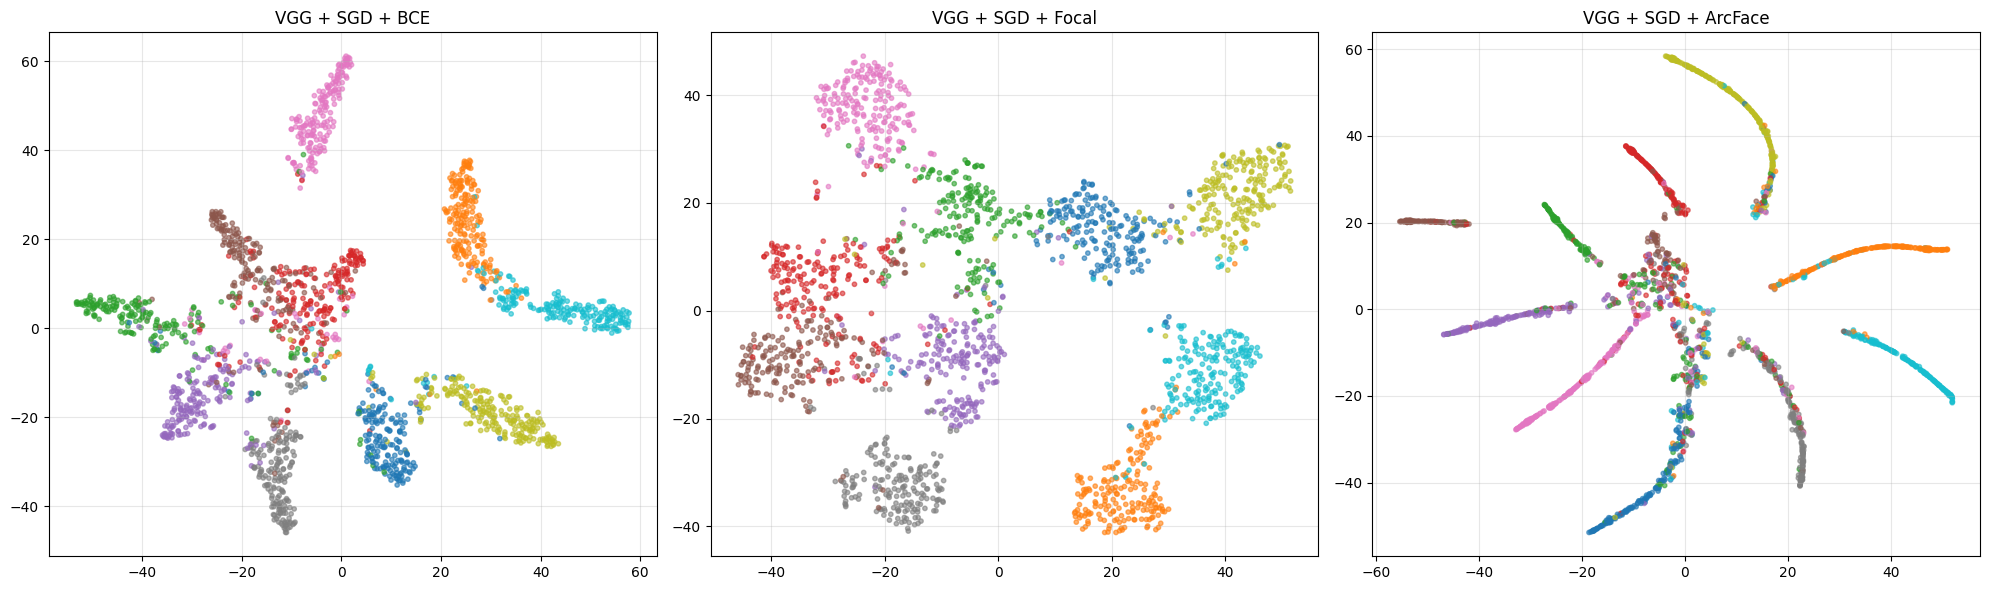

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

class BCELossWrapper(nn.Module):
    def __init__(self, num_classes=10):
        super(BCELossWrapper, self).__init__()
        self.num_classes = num_classes
        self.criterion = nn.BCEWithLogitsLoss()
    def forward(self, logits, targets):
        targets_one_hot = F.one_hot(targets, num_classes=self.num_classes).float()
        return self.criterion(logits, targets_one_hot)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        return focal_loss.mean() if self.reduction == 'mean' else focal_loss.sum()

class ArcFaceLayer(nn.Module):
    def __init__(self, in_features, out_features, s=30.0, m=0.50):
        super(ArcFaceLayer, self).__init__()
        self.s = s; self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)
    def forward(self, input, label=None):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        if label is None: return cosine * self.s
        phi = cosine - self.m
        one_hot = torch.zeros(cosine.size(), device=input.device)
        one_hot.scatter_(1, label.view(-1, 1), 1)
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

def train_and_extract(loss_name):
    print(f"\n>>> Processing: VGG + SGD + {loss_name} <<<")

    model = get_cnn_model('vgg')

    if loss_name == 'ArcFace':
        model.classifier[6] = nn.Identity()
        head = ArcFaceLayer(4096, 10).to(device)
        optimizer = optim.SGD(list(model.parameters()) + list(head.parameters()), lr=0.01, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
    else:
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        if loss_name == 'BCE': criterion = BCELossWrapper(num_classes=10)
        elif loss_name == 'Focal': criterion = FocalLoss(gamma=2)

    train_loader, test_loader, _ = get_dataloaders('CIFAR10', batch_size=128, augment=True)
    model.train()

    for epoch in tqdm(range(5), desc=f"Training {loss_name}", leave=False): #5 epochs for quick visualization.
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            if loss_name == 'ArcFace':
                features = model(images)
                outputs = head(features, labels)
            else:
                outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    features_list = []
    labels_list = []

    print(f"Extracting features for {loss_name}...")
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            if loss_name == 'ArcFace':
                feats = model(images)
            else:
                x = model.features(images)
                x = model.avgpool(x)
                x = torch.flatten(x, 1)
                classifier = model.classifier
                for i in range(len(classifier) - 1):
                    x = classifier[i](x)
                feats = x

            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    return np.concatenate(features_list), np.concatenate(labels_list)

def part3_final_visualization():
    losses = ['BCE', 'Focal', 'ArcFace']

    plt.figure(figsize=(20, 6))

    for i, loss_name in enumerate(losses):
        feats, labels = train_and_extract(loss_name)

        print(f"Computing t-SNE for {loss_name}...")
        limit = 2000
        tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
        feats_2d = tsne.fit_transform(feats[:limit])
        labels_subset = labels[:limit]

        plt.subplot(1, 3, i+1)
        scatter = plt.scatter(feats_2d[:, 0], feats_2d[:, 1], c=labels_subset, cmap='tab10', alpha=0.6, s=10)
        plt.title(f"VGG + SGD + {loss_name}")
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

part3_final_visualization()

**BCE & Focal Loss** appear as clouds. Since these losses optimize for decision boundaries. As long as the sample is on the correct side of the line the model is happy. It does not force features to be tight. Excellent for General Classification.

**ArcFace** forces the samples into distinct thin lines radiating from a central point. ArcFace forces features to be distributed by angle on a hypersphere. The thinness of the lines indicates high intra-class compactness. While it created the most distinct feature structure, it struggled to converge on this dataset.

##Conclusion


*   In **Part 1** we ran the 8 models on the CIFAR-10 dataset. We noted their accuracy, number of parameters, and time to train.
*   In **Part 2** we compared 4 selected models, the 3 Advanced Loss Functions, and 3 Optimizers to identify the best configuration for the CIFAR-10 dataset. (VGG,BCE,SGD).
*   In **Part 3** we visualized the 3 loss functions to see how they cluster the CIFAR-10 classes.

